# Navigation
## 1. Setup Environment

Make sure you have already installed the pre-requisites using:


In [1]:
# !conda env create --name drlnd_navigation --file=environment.yml
# conda activate drlnd_navigation

# !pip install -r requirements.txt

In [2]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

Download and place the correct unity environment file based on OS and arch in the folder `unity_env`.


In [3]:
env = UnityEnvironment(file_name="unity_env/Banana.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print(env_info.vector_observations.shape)
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
(1, 37)
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### Instantiate Agent with Double DQN Network

In [6]:
from dqn_agent import Agent, DoubleDQNAgent

agent = DoubleDQNAgent(state_size=state_size, action_size=action_size, seed=12)

## 3. Train the Agent with DQN

In [7]:
def get_SAR(env_info):
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]
    done = env_info.local_done[0]
    return (next_state, reward, done)

Episode 100	Average Score: 0.70	Above13: 0/100
Episode 200	Average Score: 4.10	Above13: 0/100
Episode 300	Average Score: 7.34	Above13: 5/100
Episode 400	Average Score: 10.69	Above13: 20/100
Episode 500	Average Score: 13.11	Above13: 43/100
Episode 600	Average Score: 13.96	Above13: 56/100
Episode 700	Average Score: 15.20	Above13: 74/100
Episode 800	Average Score: 14.94	Above13: 65/100
Episode 883	Average Score: 15.54
Environment solved in 783 episodes!	Average Score: 15.54


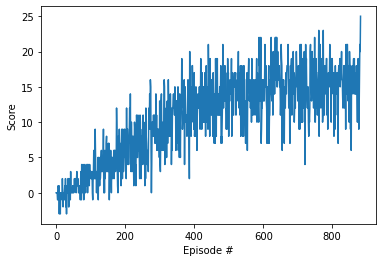

In [8]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done = get_SAR(env.step(action)[brain_name])
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tAbove13: {:d}/100'.format(\
                i_episode, np.mean(scores_window), (np.asarray(scores_window) > 13).sum()))
        if np.mean(scores_window) >= 15.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Watch a Smart Agent!

In [9]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    reward = 0
    while True:
        action = agent.act(state, 0., reward)          # select an action
        #print(action)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break

    print("Score: {}".format(score))
            


Score: 16.0
Score: 17.0
Score: 14.0


## 5. Shutdown the env

In [ ]:
env.close()